# Método de Müller para raíces de funciones algebraicas.
El algoritmo de Müller fue definido como un método iterativo para encontrar raíces de funciones algebraicas a través de la utilización de un polinomio interpolante de segundo grado que busca aproximar raíces de funciones continuas. Una particularidad del algoritmo es que como utiliza la fórmula cuadrática es capaz de encontrar raíces complejas de la función a investigar. Las iteraciones se definen como:
$$x_{n+1}=x_n - \frac{2f(x_n)}{b \pm \sqrt{b^2 - 4f(x_n)f[x_n,x_{n-1},x_{n-2}]}}$$
Donde $b = f[x_{n},x_{n-1}]+f[x_{n},x_{n-2}]-f[x_{n-1},f{x_{n-2}}]$ y $f[x_n,\ldots,x_0]$ es la operación diferencia dividida de Newton definida recursivamente como:
$$f[x_n,...,x_0] = \frac{f[x_{n-1},\ldots,x_0] - f[x_{n},\ldots,x_1]}{x_0-x_n}$$
Para la implementación se puede comenzar importando las librerías a utilizar y posteriormente definiendo una función para la operación de diferencias divididas de Newton.


In [41]:
import pandas as pd
import sympy as sp
import numpy as np 
import os as os
import matplotlib.pyplot as plt
from cmath import *

pd.set_option("display.precision", 10)

# devuelve un diccionario donde cada llave es un elemento de la tupla y cada elemento una lista vacía
def create_dictionary(tuple):
    result = {}
    for key in tuple:
        result.setdefault(key, [])
    return result

# agrega los datos especificados a una tabla
def add_info(dictionary, columns, data):
    i = 0
    for c in columns:
        dictionary[c].append(data[i])
        i += 1

Como el método solo utiliza segundas diferencias divididas se puede escribir la fórmula directamente sin necesidad de implementar recursividad o alguna técnica de memorización (como programación dinámica por ejemplo).

In [115]:
def first_divided_difference(f,x1,x0):
    return (f(x1)-f(x0))/(x1-x0)

def second_divided_difference(f,x2,x1,x0):
    return (first_divided_difference(f,x1,x0) - first_divided_difference(f,x2,x1))/(x0-x2)

Luego como datos de entrada por parte del usuario se solicitan tres puntos que aproximen alguna raíz de la función, la función y una tolerancia $\epsilon$ como condición de paro, la cual se utiliza como $|f(x)| < \epsilon$. 

In [274]:
# Dado que el algoritmo de Müller está enfocado en raíces complejas, los valores iniciales también son números complejos
x_0 = complex(0,0)
x_1 = complex(1,1)
x_2 = complex(0,1)
tol = 1e-9
# Definiendo un string que representa la función de forma simbólica utilizando x como variable
f_string = "x**5 + 11*x**4 - 21*x**3 - 10*x**2 - 21*x - 5"

Para la implementación del algoritmo se procede a calcular:
* La cantidad de iteraciones para encontrar la raíz.
* el valor de la raíz.
* el valor de la función evaluada en la raíz.

Con dichos datos también se puede mostrar que el algoritmo es capaz de encontrar múltiples raíces de una función en caso de ser necesario, esto se hace alterando la función como $g(x) = \frac{f(x)}{(x-\alpha)}$ donde $\alpha$ es una de las raíces encontradas. A esto se le conoce como supresión y puede leerse más al respecto en [Practical Problems Arising in the Solution of Polynomial Equations](https://sci-hub.se/10.1093/imamat/8.1.16).   
Aplicar el procedimiento anteriormente mencionado hará que la función termine siendo una función constante, por lo que la función incluirá un argumento opcional para definir la cantidad de raíces en caso de que la función tenga demasiadas (por ejemplo una función oscilante periódica que tiene infinitas raíces).
Con todas esas consideraciones, la implementación del algoritmo queda como

In [177]:
# Validación de la función
def valid_function(a, b, c):
    # se asume que si la diferencia relativa entre los valores es menor o igual a 1% la función es constante y por lo tanto
    # no es válida para seguir investigando raíces
    if ( isclose(a,b,rel_tol=1e-2) and isclose(a,c,rel_tol=1e-2) and isclose(b,c,rel_tol=1e-2)):
         return False
    else:
         return True

In [297]:
# Función para encontrar una raíz, devuelve una fila para formar una tabla posteriormente
def muller(x_0, x_1, x_2, f, tol, max_iterations = 100):
    # datos iniciales para el algoritmo
    a = 0 + 0j
    b = 0 + 0j
    c = 0 + 0j
    x_n = x_2
    x0, x1, x2 = x_0, x_1, x_2
    d = 0 + 0j
    e = 0 + 0j
    i = 0
    while( abs(f(x_n)) > tol and i < max_iterations ):
        try:
            a = second_divided_difference(f, x2, x1, x0)
            b = first_divided_difference(f,x2,x1) + first_divided_difference(f,x2,x0) - first_divided_difference(f,x1,x0)
            c = f(x2)
            d = sqrt(b**2 - 4*a*c)
            # Eligiendo signo para maximizar la magnitud del denominador:
            e = ( b + d ) if ( abs( b - d ) < abs( b + d ) ) else ( b - d ) 
            h = -2*c/e
            x_n = x2 + h
            x0 = x1
            x1 = x2
            x2 = x_n
            i += 1
        except ZeroDivisionError:
            print("Hubo un error de división por cero.\nIntente otros valores iniciales u otra precision")
            return i, x_n, f(x_n)
    if(i == max_iterations):
        print("No se pudo encontrar una raíz con la precisión especificada")
    return i, x_n, f(x_n)


In [266]:
# Función para encontrar hasta n raíces de la función
def find_roots(f_s, tol,x_0 = 3, x_1 = 4, x_2 = 5, max_roots = 20, max_iterations = 100):
    # datos de la tabla
    columns = ("it","root","f(r)")
    table = create_dictionary(columns)
    rows = 0 # cada fila representa una raíz
    # definiciones simbólicas
    x = sp.Symbol("x")
    f_sym = sp.sympify(f_s)
    f = sp.lambdify(x,f_sym)
    # valores iniciales
    x0, x1, x2 = x_0, x_1, x_2
    # iterando mientras sea posible encontrar una raíz utilizando el procedimiento de supresión
    while valid_function(f(x0), f(x1), f(x2)) and rows < max_roots:
        add_info(table, columns, muller(x0,x1,x2,f,tol,max_iterations))
        f_sym = f_sym/(sp.sympify(x-(table["root"][rows])))
        f = sp.lambdify(x,f_sym)
        rows += 1  

    return table
   


Como primer ejemplo se utilizará el algoritmo para encontrar las cinco raíces de la función polinómica definida anteriormente 
$$x^5 + 11x^4 - 21x^3 - 10x^2-21x-5$$
con una precisión de $\epsilon = 10^{-14}$.

In [298]:
results = find_roots(f_string,1e-15, 1+1j, 2.5, 3, 10, 500)
df = pd.DataFrame(results)
display(df)



No se pudo encontrar una raíz con la precisión especificada
No se pudo encontrar una raíz con la precisión especificada


,it,root,f(r)
0,39,1.7320357127-0.0000000128j,0.0000000000e+00-2.4788710369e-17j
1,500,1.7320568386-0.0000120204j,3.9068928851e-11+7.9198779139e-11j
2,500,1.7320580969+0.0000124646j,-2.2923544613e-06-5.1739413707e-06j
3,3,-1.1000000000-0.0000000000j,-3.9101855612e-17-1.8915296312e-20j


El siguiente ejemplo a investigar consiste en la función:
$$((x-\frac{1}{2})^2)^{\frac{1}{3}}\sqrt{x+1}-\frac{3 \cdot 7^{\frac{7}{5}} \cdot 3^{\frac{2}{3}} \cdot 2^{\frac{1}{6}}}{49}$$
Por lo que el código quedaría como:

In [299]:
f_string = "(((x-(1/2))**2)**(1/3))*(x+1)**(1/2) - (3*7**(5/6)*3**(2/3)*2**(1/6))/49"
results = find_roots(f_string, 1e-14, -1, 0, 1, 5, 1000)
df = pd.DataFrame(results)
display(df)


,it,root,f(r)
0,11,-3.5714286389e-01+1.9000218104e-08j,3.3306690739e-16+1.9643733482e-16j
1,5,8.8284894616e-01-8.2928724557e-26j,2.6860411874e-16+4.0186792003e-24j
2,949,-3.5714285714e-01-1.1152783506e-08j,8.4271218000e-17-1.8862926775e-17j
3,626,-5.2284746785e+07+3.3801069271e+06j,8.3207785462e-16-6.9973961999e-15j
4,131,-3.1578610302e+02-2.6524426694e+03j,5.1547199624e-15-8.5259946565e-15j


Una gráfica de la función permite visualizar la forma de la gráfica y dónde se ubican dos de sus raíces reales:

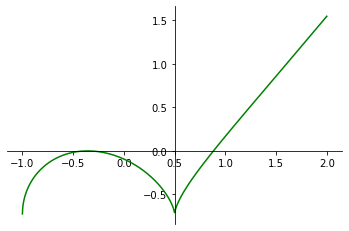

In [282]:
def draw_graph(f_s, a, b):
    xarr = np.linspace(a,b,1000)
    x = sp.Symbol("x")
    g = sp.lambdify(x,f_s)
    out = g(xarr)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # plot the function
    plt.plot(xarr,out, 'g')

    # show the plot
    plt.show()


draw_graph(f_string,-1,2)

Lo cual demuestra que la implementación del algoritmo pudo encontrar las raíces reales con pocas iteraciones, también se puede observar que para encontrar algunas raíces complejas fueron necesarias casi 1000 iteraciones en un caso.
La siguiente función a considerar es una que presente un comportamiento oscilatorio como lo es la función $\frac{\sin{x}}{x}$ por lo que a continuación se muestra una búsqueda de 10 raíces de la función teniendo el cuidado de no escoger cero como punto inicial pues la función es discontinua en tal nodo.

In [300]:
f_string = "sin(x)/x"
results = find_roots(f_string, 1e-14, 1, 1.5, 2, 10, 1000)
df = pd.DataFrame(results)
display(df)

,it,root,f(r)
0,6,3.1415926536+0.0000000000j,3.8981718325e-17-0.0000000000e+00j
1,7,6.2831853072+0.0000000000j,-1.2408266323e-17+0.0000000000e+00j
2,7,-3.1415926536+0.0000000000j,1.6536770107e-16+0.0000000000e+00j
3,9,9.4247779608+0.0000000000j,1.5715252885e-19-5.1701339528e-20j
4,13,-9.4247779608-0.0000000001j,-3.5088524973e-16-6.1394137363e-16j
5,6,-6.2831853063-0.0000000000j,-7.4230824358e-15+1.4742462607e-23j
6,19,18.8495559216+0.0000000000j,1.9736803845e-19+7.7601135415e-20j
7,13,15.7079632710-0.0000000141j,8.0788657452e-18-3.6887612106e-17j
8,23,-21.9912375827+0.0005987799j,-3.1697496301e-17+2.1288795639e-16j


Por último se busca encontrar las 4 raíces del polinomio:
$$x^4-4.096152422706631x^3+3.284232335022705x^2+4.703847577293368x-5.715767664977294$$  
pero sin coincidir el número máximo de raíces a encontrar con el grado del polinomio

In [301]:
f_string = "x**4 - 4.096152422706631*x**3 + 3.284232335022705*x**2 + 4.703847577293368*x - 5.715767664977294"
results = find_roots(f_string, 1e-14, 1, 1+1j, 2, 13, 1000)
df = pd.DataFrame(results)
display(df)

No se pudo encontrar una raíz con la precisión especificada
No se pudo encontrar una raíz con la precisión especificada


,it,root,f(r)
0,34,1.7320362525-0.0000053471j,0.0000000000e+00-9.1912934241e-15j
1,1000,1.7320581844-0.0000131159j,-7.6639072809e-11-1.2295114629e-11j
2,1000,1.7320579985+0.0000128452j,-1.9334942227e-06-1.5242639413e-06j
3,3,-1.1000000000-0.0000000000j,-3.9101758806e-17-3.6359797978e-17j


De los datos es posible evidenciar que las dos raíces que no fueron posibles de encontrar con la precisión especificada fueron las raíces complejas. De aquí sería posible notar las limitaciones del método considerando la supresión y cómo afecta en casos donde la cantidad de cifras significativas es muy exacta (como el polinomio anterior donde la función está definida con muchos decimales).

Igualmente en otros ejemplos vistos en esta presentación es posible encontrar casos donde el algoritmo si bien aproximó una raíz no fue capaz de lograr la precisión especificada.